# Air spring calculator

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#constants
AREA_POS_PISTON = np.pi * (32 - 2*2.05) ** 2 / 4
AREA_NEG_PISTON = AREA_POS_PISTON - np.pi * 10 ** 2 / 4
LEFT_LEG_AREA = np.pi * 32 ** 2 / 4 - np.pi * 10 ** 2 / 4
RIGHT_LEG_AREA = np.pi * 32 ** 2 / 4 - np.pi * 12 ** 2 / 4
LEG_AREA = np.pi * 38 ** 2 / 4 

NEG_FILL_COEFF = 0.9

In [11]:
# stock condition with 110mm of travel
def get_spring_force(x, h_pos_ini = 170, h_neg_ini = 60 ):
    p_ini = 63 * 0.00689475728 #N/mm2
    #TODO: make this function accept sag, not pressure
    
    v_pos_ini = h_pos_ini * AREA_POS_PISTON
    v_neg_ini = h_neg_ini * AREA_NEG_PISTON * NEG_FILL_COEFF

    v_pos = v_pos_ini - x * AREA_POS_PISTON
    p_pos = p_ini * v_pos_ini / v_pos
    f_pos = p_pos * AREA_POS_PISTON
    
    v_neg = v_neg_ini + x * AREA_NEG_PISTON
    p_neg = p_ini * v_neg_ini / v_neg
    f_neg = - p_neg * AREA_NEG_PISTON
#     print(f_pos)
#     print(f_neg)
    
    return f_pos + f_neg


def get_spring_rate(x):
    STEP = 1
    return (get_spring_force(x + 0.5*STEP) - get_spring_force(x - 0.5*STEP)) / STEP

In [5]:
#unit testing
assert(abs(AREA_POS_PISTON - AREA_NEG_PISTON == np.pi * 10 ** 2 / 4) < 0.01)
assert(abs(get_spring_force(0) == 63 * 0.00689475728 * np.pi * 5 **2) < 0.01)

In [6]:
110*0.25

27.5

In [7]:
sag_force = get_spring_force(110*0.25)
sag_force

163.45699991135683

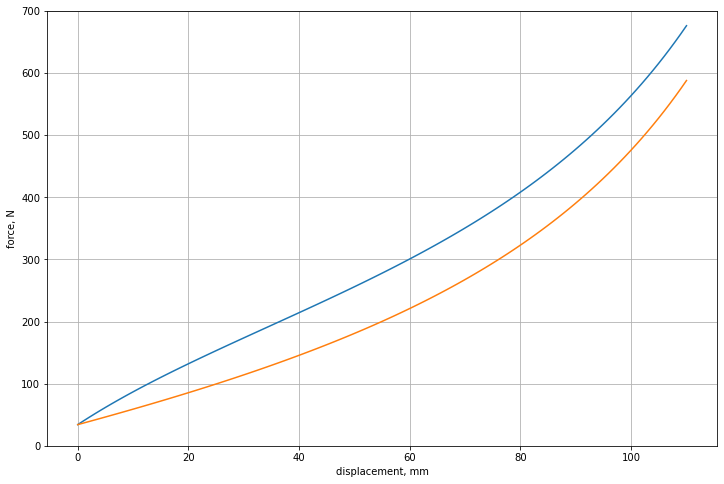

In [10]:
get_spring_force_v = np.vectorize(get_spring_force)
x = np.linspace(0, 110, 110)
y = get_spring_force_v(x)
y2 = get_spring_force_v(x, h_neg_ini = 300)


plt.figure(figsize=(12,8))
plt.plot(x, y)
plt.plot(x, y2)

plt.xlabel("displacement, mm")
plt.ylabel("force, N")

plt.ylim(0, 700)
plt.grid()
plt.show()

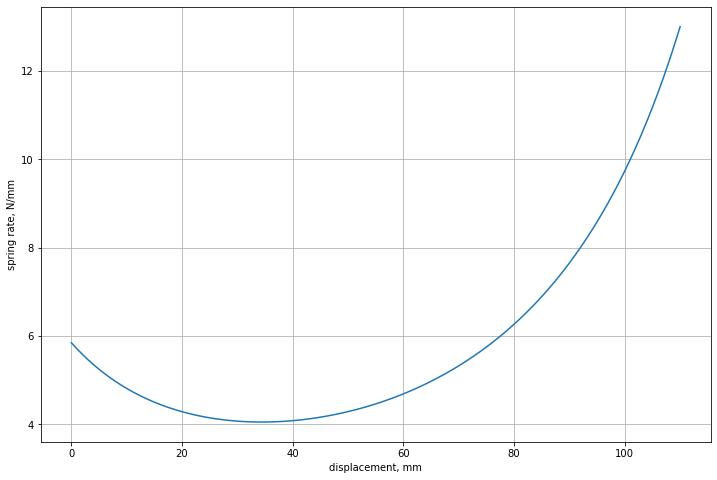

In [9]:
get_spring_rate_v = np.vectorize(get_spring_rate)
x = np.linspace(0, 110, 110)
y = get_spring_rate_v(x)

plt.figure(figsize=(12,8))
plt.plot(x, y)
plt.xlabel("displacement, mm")
plt.ylabel("spring rate, N/mm")

# plt.ylim(0, 700)
plt.grid()
plt.show()